In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '/scratch/xhuan_root/xhuan1/wgshen/vsOED/'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel

In [2]:
n_stage      = 5       # Number of stages.
n_design     = 2        # Number of design variables.
n_obs        = 1        # Number of observations.
n_pois       = [4]        # Number of parameters.
n_nuisps     = None
n_goals      = None
model_weight = 0
poi_weight   = 1
goal_weight  = 0

n_incre = 1
folder = parent_dir + f'experiments/source_{len(n_pois)}model_{n_stage}stage_{n_incre}incre_GMM/'

random_state  = TRAIN_SEEDS[0]
set_random_seed(random_state)

model = SOURCE(multimodel=False, include_nuisance=False, include_goal=False)
prior = model

mu_bounds = {}
mu_bounds['poi'] = []
for n_poi in n_pois:
    mu_bounds['poi'].append([[-6, 6]] * n_poi)
if n_goals is not None:
    mu_bounds['goal'] = []
    for n_goal in n_goals:
        mu_bounds['goal'].append([[0, 3]] * n_goal)
max_sigmas = {}
max_sigmas['poi'] = []
for n_poi in n_pois:
    max_sigmas['poi'].append([1.0] * n_poi)
if n_goals is not None:
    max_sigmas['goal'] = []
    for n_goal in n_goals:
        max_sigmas['goal'].append([1.0] * n_goal)
truncnorm_info = {}
truncnorm_info['poi'] = [None] * len(n_pois)
if n_goals is not None:
    truncnorm_info['goal'] = []
    for n_goal in n_goals:
        info = []
        for i in range(n_goal):
            info.append([i, 0, 4])
            
n_incre = 1
share_interm_net = False

candidate_lrs = [[1e-3] * n_incre, [1e-4] * (n_incre - 1) + [1e-3]]
candidate_gammas = [[0.9999] * n_incre, [0.999999] * (n_incre - 1) + [0.9999]]
model_post_lrs = candidate_lrs[share_interm_net]
model_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
poi_post_lrs = candidate_lrs[share_interm_net]
poi_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
goal_post_lrs = candidate_lrs[share_interm_net]
goal_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]

use_NFs = False
n_mixture = 8
activate = nn.ReLU

log_every = 100
folder = parent_dir + f'experiments/source_{len(n_pois)}model_{n_stage}stage_{n_incre}incre_GMM/'
try:
    os.remove(folder + 'progress.csv')
except:
    pass
try:
    os.remove(folder + 'progress.txt')
except:
    pass
try:
    dowel.logger.remove_all()
except:
    pass
dowel.logger.add_output(dowel.StdOutput())
dowel.logger.add_output(dowel.CsvOutput(folder + 'progress.csv'))
dowel.logger.add_output(dowel.TextOutput(folder + 'progress.txt'))

try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
dowel.logger.log('Stored at ' + folder)
dowel.logger.log('Random seed:  ' + str(random_state))
dowel.logger.log('Device: ' + str(device))
dowel.logger.log('dtype: ' + str(dtype))

post_approx_params = {
    'n_stage': n_stage, 
    'n_design': n_design, 
    'n_obs': n_obs, 
    'n_pois': n_pois,
    'n_nuisps': n_nuisps,
    'n_goals': n_goals,
    'model_weight': model_weight,
    'poi_weight': poi_weight,
    'goal_weight': goal_weight,
    'mu_bounds': mu_bounds,
    'max_sigmas': max_sigmas,
    'truncnorm_info': truncnorm_info,
    'n_mixture': n_mixture,
    'activate': activate,
    'prior': prior,
    'n_incre': n_incre,
    'share_interm_net': share_interm_net,
    'model_post_lrs': model_post_lrs,
    'model_post_lr_scheduler_gammas': model_post_lr_scheduler_gammas,
    'poi_post_lrs': poi_post_lrs,
    'poi_post_lr_scheduler_gammas': poi_post_lr_scheduler_gammas,
    'goal_post_lrs': goal_post_lrs,
    'goal_post_lr_scheduler_gammas': goal_post_lr_scheduler_gammas,
    'use_NFs': use_NFs,
    'log_every': log_every,
    'dowel': dowel}

dowel.logger.log('Post_approx_params: ' + str(post_approx_params))

dowel.logger.dump_all()
# dowel.logger.remove_all()

post_approx = POST_APPROX(**post_approx_params)
dowel.logger.dump_all()

2023-05-01 16:39:20 | [SOURCE] Stored at /scratch/xhuan_root/xhuan1/wgshen/vsOED/experiments/source_1model_5stage_1incre_GMM/
2023-05-01 16:39:20 | [SOURCE] Random seed:  48563549
2023-05-01 16:39:20 | [SOURCE] Device: cuda:0
2023-05-01 16:39:20 | [SOURCE] dtype: torch.float32
2023-05-01 16:39:20 | [SOURCE] Post_approx_params: {'n_stage': 5, 'n_design': 2, 'n_obs': 1, 'n_pois': [4], 'n_nuisps': None, 'n_goals': None, 'model_weight': 0, 'poi_weight': 1, 'goal_weight': 0, 'mu_bounds': {'poi': [[[-6, 6], [-6, 6], [-6, 6], [-6, 6]]]}, 'max_sigmas': {'poi': [[1.0, 1.0, 1.0, 1.0]]}, 'truncnorm_info': {'poi': [None]}, 'n_mixture': 8, 'activate': <class 'torch.nn.modules.activation.ReLU'>, 'prior': <vsOED.models.SOURCE object at 0x14d25f80e790>, 'n_incre': 1, 'share_interm_net': False, 'model_post_lrs': [0.001], 'model_post_lr_scheduler_gammas': [0.9999], 'poi_post_lrs': [0.001], 'poi_post_lr_scheduler_gammas': [0.9999], 'goal_post_lrs': [0.001], 'goal_post_lr_scheduler_gammas': [0.9999], 'use

In [3]:
n_param = len(n_pois) > 1
try:
    n_param += max(n_pois)
except:
    pass
try:
    n_param += max(n_nuisps)
except:
    pass
try:
    n_param += max(n_goals)
except:
    pass

design_bounds = [(-4, 4), (-4, 4)] # lower and upper bounds of design variables.
def reward_fun(*args, **kws):
    return 0
nkld_reward_fun = reward_fun
kld_reward_fun = post_approx.reward_fun
phys_state_info = None
post_approx = post_approx
encoder_dimns = None
backend_dimns = None
actor_dimns = [256, 256, 256]
critic_dimns = [256, 256, 256]

vsoed_params = {
    'n_stage': n_stage,
    'n_param': n_param,
    'n_design': n_design,
    'n_obs': n_obs,
    'model': model,
    'prior': prior,
    'design_bounds': design_bounds,
    'nkld_reward_fun': nkld_reward_fun,
    'kld_reward_fun': kld_reward_fun,
    'phys_state_info': phys_state_info,
    'post_approx': post_approx,
    'encoder_dimns': encoder_dimns,
    'backend_dimns': backend_dimns,
    'actor_dimns': actor_dimns,
    'critic_dimns': critic_dimns,
    'activate': activate
}
dowel.logger.log('vsoed_params: ' + str(vsoed_params))

vsoed = PGvsOED(**vsoed_params)

2023-05-01 16:39:22 | [SOURCE] vsoed_params: {'n_stage': 5, 'n_param': 4, 'n_design': 2, 'n_obs': 1, 'model': <vsOED.models.SOURCE object at 0x14d25f80e790>, 'prior': <vsOED.models.SOURCE object at 0x14d25f80e790>, 'design_bounds': [(-4, 4), (-4, 4)], 'nkld_reward_fun': <function reward_fun at 0x14d25b48f310>, 'kld_reward_fun': <bound method POST_APPROX.reward_fun of <vsOED.post_approx.POST_APPROX object at 0x14d25b4fb520>>, 'phys_state_info': None, 'post_approx': <vsOED.post_approx.POST_APPROX object at 0x14d25b4fb520>, 'encoder_dimns': None, 'backend_dimns': None, 'actor_dimns': [256, 256, 256], 'critic_dimns': [256, 256, 256], 'activate': <class 'torch.nn.modules.activation.ReLU'>}


In [4]:
vsoed.post_approx.poi_post_nets[4][0].state_dict()

OrderedDict([('feature_net.0.weight',
              tensor([[-0.0058, -0.2213, -0.0723,  ...,  0.0866, -0.2154, -0.0872],
                      [ 0.0742, -0.1699,  0.2476,  ...,  0.1467, -0.0421,  0.1695],
                      [ 0.2384,  0.1880, -0.0225,  ..., -0.0855,  0.0570, -0.2414],
                      ...,
                      [-0.1516, -0.1265, -0.0076,  ...,  0.1919, -0.0867, -0.1272],
                      [-0.1564, -0.0785,  0.1847,  ...,  0.0815,  0.2044,  0.1007],
                      [-0.0215,  0.2493,  0.1176,  ..., -0.1363, -0.1144, -0.0003]],
                     device='cuda:0')),
             ('feature_net.0.bias',
              tensor([ 4.2562e-02, -5.8071e-02,  1.4590e-01, -1.0990e-01, -5.6038e-02,
                       7.5088e-02, -1.7228e-01, -3.0644e-02,  2.3223e-01,  3.8116e-02,
                      -2.3504e-01,  1.4797e-01,  2.2552e-01,  1.0513e-01, -2.5603e-01,
                       2.6685e-02,  2.0664e-01, -1.6646e-01,  2.2838e-01,  1.7301e-04,
      

In [5]:
import joblib

vsoed = joblib.load(folder + 'itr_1000.pkl')

In [6]:
vsoed.post_approx.poi_post_nets[4][0].state_dict()

OrderedDict([('feature_net.0.weight',
              tensor([[-0.0470, -0.2051, -0.0392,  ...,  0.0693, -0.1757, -0.0904],
                      [ 0.1389, -0.1869,  0.1779,  ...,  0.1394, -0.0184,  0.1060],
                      [ 0.2448,  0.2416,  0.0044,  ..., -0.2091,  0.0314, -0.1443],
                      ...,
                      [-0.0573, -0.0680, -0.0132,  ...,  0.1755, -0.0962, -0.0753],
                      [-0.0502, -0.2528,  0.0463,  ..., -0.0056,  0.1077,  0.0613],
                      [ 0.2163,  0.3165,  0.0154,  ..., -0.0520, -0.1544,  0.0305]],
                     device='cuda:0')),
             ('feature_net.0.bias',
              tensor([ 0.0383, -0.1691,  0.2780, -0.1853, -0.1674,  0.0265, -0.1015,  0.0877,
                       0.4038, -0.0053, -0.2885,  0.1407,  0.4398,  0.0882, -0.2900, -0.0653,
                       0.1375, -0.2107,  0.3477, -0.1224, -0.1177,  0.1916,  0.1396,  0.0468,
                      -0.2490, -0.2148,  0.3585, -0.1689, -0.1037, -0.21

In [4]:
import joblib

joblib.dump(vsoed, folder + 'itr_0.pkl')

['/scratch/xhuan_root/xhuan1/wgshen/vsOED/experiments/source_1model_5stage_1incre_GMM/itr_0.pkl']

In [11]:
from pprint import pformat as pf 
import pickle

In [14]:
def pickle_trick(obj, max_depth=10):
    output = {}
 
    if max_depth <= 0:
        return output
 
    try:
        pickle.dump(obj, folder + 'itr_0.pkl')
    except (pickle.PicklingError, TypeError) as e:
        failing_children = []
 
        if hasattr(obj, "__dict__"):
            for k, v in obj.__dict__.items():
                result = pickle_trick(v, max_depth=max_depth - 1)
                if result:
                    failing_children.append(result)
 
        output = {
            "fail": obj, 
            "err": e, 
            "depth": max_depth, 
            "failing_children": failing_children
        }
 
    return output

In [15]:
print(pf(pickle_trick(vsoed)))

/home/wgshen/.local/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


RuntimeError: dictionary changed size during iteration

In [7]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(2000, n_contrastive_sample=int(1e6), return_all=True, save_path=folder+'eval_results.pt', dowel=dowel)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

100%|██████████| 2000/2000 [00:07<00:00, 251.36it/s]

2023-05-01 16:39:37 | [SOURCE] Evaluation finished...
2023-05-01 16:39:37 | [SOURCE] 1-horizon averaged reward: 0.782
2023-05-01 16:39:37 | [SOURCE] 2-horizon averaged reward: 1.577
2023-05-01 16:39:37 | [SOURCE] 3-horizon averaged reward: 2.358
2023-05-01 16:39:37 | [SOURCE] 4-horizon averaged reward: 2.912
2023-05-01 16:39:37 | [SOURCE] 5-horizon averaged reward: 3.619
2023-05-01 16:39:37 | [SOURCE] total averaged reward: 3.619
2023-05-01 16:39:37 | [SOURCE] total reward se: 0.043


3.619488477706909

In [8]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(int(1e5), use_PCE=False, n_contrastive_sample=int(1e6), return_all=True, save_path=folder+'eval_results.pt', dowel=dowel)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

2023-05-01 16:39:55 | [SOURCE] Evaluation finished...
2023-05-01 16:39:55 | [SOURCE] 1-horizon averaged reward: 0.000
2023-05-01 16:39:55 | [SOURCE] 2-horizon averaged reward: 0.000
2023-05-01 16:39:55 | [SOURCE] 3-horizon averaged reward: 0.000
2023-05-01 16:39:55 | [SOURCE] 4-horizon averaged reward: 0.000
2023-05-01 16:39:55 | [SOURCE] 5-horizon averaged reward: 2.562
2023-05-01 16:39:55 | [SOURCE] total averaged reward: 2.562
2023-05-01 16:39:55 | [SOURCE] total reward se: 0.005


2.56229829788208

In [4]:
actor_lr = 1e-3
actor_lr_scheduler_gamma = 0.9999
critic_lr = 1e-3
critic_lr_scheduler_gamma = 0.9999
    
n_update = 10001
n_newtraj = 1000
n_batch = 10000
n_buffer_init = n_batch * 2
n_buffer_max = int(1e6)
buffer_device = torch.device('cuda')
discount = 1 if n_incre == 1 else 0.9
encoder_actor_optimizer = None
encoder_actor_lr_scheduler = None
encoder_critic_optimizer = None
encoder_critic_lr_scheduler = None
actor_optimizer = optim.Adam(vsoed.actor_net.parameters(), lr=actor_lr)
actor_lr_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=actor_lr_scheduler_gamma)
n_critic_update = 5
critic_optimizer = optim.Adam(vsoed.critic_net.parameters(), lr=critic_lr)
critic_lr_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=critic_lr_scheduler_gamma)
n_post_approx_update = 5
lr_target = 0.1
design_noise_scale = 0.5
design_noise_decay = 0.9999
on_policy = False
use_PCE = False
use_PCE_incre = None
n_contrastive_sample = None
transition = 10000 if n_incre == 1 else 0
frozen = -1
log_every = 100
save_every = 1000
save_path = folder
restart = False

vsoed_train_params = {
    'n_update': n_update,
    'n_newtraj': n_newtraj,
    'n_batch': n_batch,
    'n_buffer_init': n_buffer_init,
    'n_buffer_max': n_buffer_max,
    'buffer_device': buffer_device,
    'discount': discount,
    'encoder_actor_optimizer': encoder_actor_optimizer,
    'encoder_actor_lr_scheduler': encoder_actor_lr_scheduler,
    'encoder_critic_optimizer': encoder_critic_optimizer,
    'encoder_critic_lr_scheduler': encoder_critic_lr_scheduler,
    'actor_lr': actor_lr,
    'actor_optimizer': actor_optimizer,
    'actor_lr_scheduler_gamma': actor_lr_scheduler_gamma, 
    'actor_lr_scheduler': actor_lr_scheduler,
    'n_critic_update': n_critic_update,
    'critic_lr': critic_lr,
    'critic_optimizer': critic_optimizer,
    'critic_lr_scheduler_gamma': critic_lr_scheduler_gamma,
    'critic_lr_scheduler': critic_lr_scheduler,
    'n_post_approx_update': n_post_approx_update,
    'lr_target': lr_target,
    'design_noise_scale': design_noise_scale,
    'design_noise_decay': design_noise_decay,
    'on_policy': on_policy,
    'use_PCE': use_PCE,
    'use_PCE_incre': use_PCE_incre,
    'n_contrastive_sample': n_contrastive_sample,
    'transition': transition,
    'frozen': frozen,
    'log_every': log_every,
    'dowel': dowel,
    'save_every': save_every,
    'save_path': save_path,
    'restart': restart
}

dowel.logger.log('vsoed_train_params: ' + str(vsoed_train_params))

del vsoed_train_params['actor_lr']
del vsoed_train_params['actor_lr_scheduler_gamma']
del vsoed_train_params['critic_lr']
del vsoed_train_params['critic_lr_scheduler_gamma']

2023-05-01 15:18:07 | [SOURCE] vsoed_train_params: {'n_update': 10001, 'n_newtraj': 1000, 'n_batch': 10000, 'n_buffer_init': 20000, 'n_buffer_max': 1000000, 'buffer_device': device(type='cuda'), 'discount': 1, 'encoder_actor_optimizer': None, 'encoder_actor_lr_scheduler': None, 'encoder_critic_optimizer': None, 'encoder_critic_lr_scheduler': None, 'actor_lr': 0.001, 'actor_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'actor_lr_scheduler_gamma': 0.9999, 'actor_lr_scheduler': <torch.optim.lr_scheduler.ExponentialLR object at 0x146af171cd90>, 'n_critic_update': 5, 'critic_lr': 0.001, 'critic_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 

In [5]:
try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
vsoed.train(**vsoed_train_params)

2023-05-01 15:18:08 | [SOURCE] epoch #0 | log param_of_interest post after training: -6.9063944816589355
2023-05-01 15:18:08 | [SOURCE] epoch #0 | Total time 0.56 s
2023-05-01 15:18:08 | [SOURCE] epoch #0 | Epoch time 0.13 s
------------------------  --------------------------------------------
Design/MeanDesign         [0.006484095472842455, -0.05642776936292648]
Design/StdDesign          [0.03164012357592583, 0.038762424141168594]
Epoch                     0
ReplayBuffer/buffer_size  20000
Reward/MeanReward         -3.0918924808502197
Reward/StdReward          4.054930210113525
------------------------  --------------------------------------------


/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Epoch: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Reward/MeanReward: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Reward/StdReward: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Design/MeanDesign: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Design/StdDesign: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInpu

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(vsoed.update_hist[:])
plt.xlabel('update', fontsize=20)
plt.ylabel('averaged reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='--')

In [ ]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(2000, n_contrastive_sample=int(1e6), return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

In [23]:
ds_hist[30]

tensor([[-0.7289,  0.6698],
        [ 0.8817,  1.2228],
        [ 1.4341,  0.6463],
        [ 1.0733, -1.2968],
        [-0.8485, -0.9864],
        [ 0.3985,  0.4226],
        [ 0.2888, -0.5700],
        [ 0.0655, -0.3715],
        [-0.0392, -0.7437],
        [ 0.2918, -0.7857]], device='cuda:0')

In [25]:
rewards_hist[:, :5].sum(-1).mean()

tensor(3.6108, device='cuda:0')

In [35]:
p_max = torch.arange(1, vsoed.n_buffer_max + 1).to(torch.float32)
l_buffer = 1000000
p = p_max[:l_buffer]
p /= p.sum()
idxs_pick = torch.multinomial(p, vsoed.n_batch, replacement=False)

(array([ 112.,  307.,  480.,  745.,  934., 1096., 1278., 1487., 1672.,
        1889.]),
 array([ 10025. , 109021.9, 208018.8, 307015.7, 406012.6, 505009.5,
        604006.4, 703003.3, 802000.2, 900997.1, 999994. ]),
 <BarContainer object of 10 artists>)

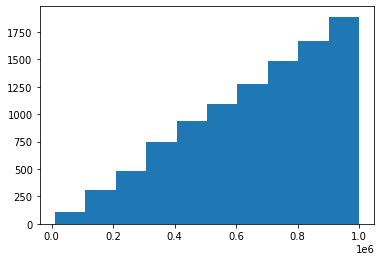

In [36]:
plt.hist(idxs_pick.cpu().numpy())

In [6]:
import joblib

In [7]:
joblib.dump(vsoed, folder + 'itr_0.pkl')

TypeError: cannot pickle 'module' object

In [9]:
vsoed.nkld_rw_f

<function vsOED.vsoed.VSOED.__init__.<locals>.nkld_rw_f(*args, **kws)>

In [51]:
torch.tensor(())

tensor([])

In [36]:
{'a': 1}.update({'b': 5})

In [10]:
np.random.choice(int(1e10), 10)

array([6377791278, 7037998855, 7556092991, 8217385358, 8695645867,
       1645853955, 1283211782, 8616980401, 3169416485, 1613878827])

In [ ]:
dict().update